# 🧬 Algoritma Genetika untuk Penentuan Kelompok KKM Reguler
## UIN Malang - Kaggle Version

---

**Platform**: Kaggle Notebook  
**Dataset**: Upload `master_data.csv` ke Kaggle Dataset

**Tujuan**: Mengelompokkan mahasiswa ke dalam kelompok-kelompok KKM Reguler yang optimal dengan mempertimbangkan:
- ✅ Keberadaan anggota HTQ
- ✅ Heterogenitas jurusan
- ✅ Proporsi jenis kelamin
- ✅ Jumlah anggota per kelompok

**Metode**: Genetic Algorithm dengan PMX Crossover dan Reciprocal Exchange Mutation

---

### 📋 Langkah Setup di Kaggle:
1. Upload dataset `master_data.csv` ke Kaggle Dataset
2. Add dataset ke notebook ini
3. Run all cells
4. Download hasil dari Output section

## 1. Import Libraries & Setup Environment

In [40]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime
import os
import glob

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"   Pandas: {pd.__version__}")
print(f"   Numpy: {np.__version__}")

# Detect environment (Kaggle vs Local)
if os.path.exists('/kaggle/input'):
    print("🌐 Running on KAGGLE environment")
    KAGGLE_MODE = True
    INPUT_DIR = '/kaggle/input'
    OUTPUT_DIR = '/kaggle/working'
else:
    print("💻 Running on LOCAL environment")
    KAGGLE_MODE = False
    INPUT_DIR = '../data'
    OUTPUT_DIR = '../output'

print(f"   Input directory: {INPUT_DIR}")
print(f"   Output directory: {OUTPUT_DIR}")

# Create output directory structure
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/hasil', exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/statistik', exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/plot', exist_ok=True)

print(f"   📁 Output structure:")
print(f"      - {OUTPUT_DIR}/hasil (grouping results)")
print(f"      - {OUTPUT_DIR}/statistik (GA statistics)")
print(f"      - {OUTPUT_DIR}/plot (convergence plots)")

✅ Libraries imported successfully!
   Pandas: 2.3.3
   Numpy: 2.3.4
💻 Running on LOCAL environment
   Input directory: ../data
   Output directory: ../output
   📁 Output structure:
      - ../output/hasil (grouping results)
      - ../output/statistik (GA statistics)
      - ../output/plot (convergence plots)


## 2. Load and Validate Data

In [41]:
# Auto-detect CSV file in Kaggle or local
if KAGGLE_MODE:
    # Find CSV file in Kaggle input
    csv_files = glob.glob(f'{INPUT_DIR}/**/*.csv', recursive=True)
    if csv_files:
        csv_path = csv_files[0]
        print(f"📁 Found dataset: {csv_path}")
    else:
        raise FileNotFoundError("No CSV file found in Kaggle input. Please add dataset!")
else:
    csv_path = f'{INPUT_DIR}/master_data.csv'

# Load data
df = pd.read_csv(csv_path)

# Validate required columns
required_cols = ['ID', 'Jenis Kelamin', 'Jurusan', 'HTQ']
assert all(col in df.columns for col in required_cols), f"Missing columns! Required: {required_cols}"

# Check missing values
missing_count = df[required_cols].isnull().sum().sum()
assert missing_count == 0, f"Found {missing_count} missing values!"

# Check duplicate IDs
dup_count = df['ID'].duplicated().sum()
assert dup_count == 0, f"Found {dup_count} duplicate IDs!"

print("="*80)
print("✅ DATA VALIDATION PASSED")
print("="*80)
print(f"Total Mahasiswa: {len(df)}")
print(f"Jumlah Jurusan: {df['Jurusan'].nunique()}")
print(f"\nDistribusi Jenis Kelamin:")
print(df['Jenis Kelamin'].value_counts())
print(f"\nDistribusi HTQ:")
print(df['HTQ'].value_counts())
print(f"\nTop 5 Jurusan:")
print(df['Jurusan'].value_counts().head())
print("\nSample Data:")
df.head(10)

✅ DATA VALIDATION PASSED
Total Mahasiswa: 2338
Jumlah Jurusan: 24

Distribusi Jenis Kelamin:
Jenis Kelamin
PR    1391
LK     947
Name: count, dtype: int64

Distribusi HTQ:
HTQ
Tidak    2112
Ya        226
Name: count, dtype: int64

Top 5 Jurusan:
Jurusan
MANAJEMEN                    248
PSIKOLOGI                    218
BAHASA DAN SASTRA ARAB       184
BAHASA DAN SASTRA INGGRIS    183
HUKUM BISNIS SYARI'AH        177
Name: count, dtype: int64

Sample Data:


,ID,Jenis Kelamin,Jurusan,HTQ
0,1,PR,BAHASA DAN SASTRA INGGRIS,Tidak
1,2,PR,BIOLOGI,Tidak
2,3,PR,TEKNIK INFORMATIKA,Tidak
3,4,LK,BAHASA DAN SASTRA ARAB,Tidak
4,5,LK,ILMU AL-QUR`AN DAN TAFSIR,Tidak
5,6,PR,AL-AHWAL AL-SYAKHSHIYYAH,Tidak
6,7,PR,PSIKOLOGI,Tidak
7,8,PR,PERBANKAN SYARI`AH,Tidak
8,9,LK,HUKUM BISNIS SYARI'AH,Tidak
9,10,LK,MANAJEMEN,Tidak


## 3. Data Preprocessing

In [42]:
def preprocess_data(df, jumlah_kelompok):
    """Preprocess data dan hitung semua statistik yang diperlukan"""
    df_clean = df.copy()
    
    # Normalize HTQ to binary
    df_clean['HTQ'] = df_clean['HTQ'].apply(lambda x: 1 if str(x).lower() in ['ya', 'lulus', '1'] else 0)
    
    # Calculate aggregate statistics
    N = len(df_clean)
    L = (df_clean['Jenis Kelamin'] == 'LK').sum()
    P = (df_clean['Jenis Kelamin'] == 'PR').sum()
    K = jumlah_kelompok
    
    # Calculate expected proportions
    PL = L / N
    PP = P / N
    
    # Calculate expected sizes per group
    A = N // K
    sisa = N % K
    
    expected_sizes = [A + 1 if i < sisa else A for i in range(K)]
    
    # Max fitness
    max_fitness = K * 4
    
    return {
        'df_clean': df_clean, 'N': N, 'L': L, 'P': P, 'K': K,
        'PL': PL, 'PP': PP, 'A': A, 'sisa': sisa,
        'expected_sizes': expected_sizes, 'max_fitness': max_fitness
    }

# Set jumlah kelompok - ADJUST THIS VALUE
JUMLAH_KELOMPOK = 190

# Preprocess
preprocessed = preprocess_data(df, JUMLAH_KELOMPOK)
df_clean = preprocessed['df_clean']

print("="*80)
print("✅ PREPROCESSING COMPLETE")
print("="*80)
print(f"Total Mahasiswa (N): {preprocessed['N']}")
print(f"Laki-laki (L): {preprocessed['L']} ({preprocessed['PL']:.2%})")
print(f"Perempuan (P): {preprocessed['P']} ({preprocessed['PP']:.2%})")
print(f"Jumlah Kelompok (K): {preprocessed['K']}")
print(f"Base size: {preprocessed['A']}, Sisa: {preprocessed['sisa']}")
print(f"Expected sizes: {preprocessed['expected_sizes'][:5]}... (first 5)")
print(f"Max Fitness: {preprocessed['max_fitness']}")

✅ PREPROCESSING COMPLETE
Total Mahasiswa (N): 2338
Laki-laki (L): 947 (40.50%)
Perempuan (P): 1391 (59.50%)
Jumlah Kelompok (K): 190
Base size: 12, Sisa: 58
Expected sizes: [13, 13, 13, 13, 13]... (first 5)
Max Fitness: 760


## 4. Constraint Evaluation Functions

In [43]:
def evaluate_C1(group_df):
    """C1: Minimal ada 1 anggota HTQ di kelompok"""
    htq_count = group_df['HTQ'].sum()
    return 1 if htq_count >= 1 else 0

def evaluate_C2(group_df):
    """C2: Jumlah jurusan berbeda > 50% dari ukuran kelompok"""
    unique_majors = group_df['Jurusan'].nunique()
    threshold = len(group_df) * 0.5
    return 1 if unique_majors > threshold else 0

def evaluate_C3(group_df, PL, PP):
    """C3: Proporsi gender menyimpang ±10% dari proporsi ideal"""
    n_group = len(group_df)
    lk_count = (group_df['Jenis Kelamin'] == 'LK').sum()
    pr_count = (group_df['Jenis Kelamin'] == 'PR').sum()
    
    lk_prop = lk_count / n_group
    pr_prop = pr_count / n_group
    
    lk_dev = abs(lk_prop - PL)
    pr_dev = abs(pr_prop - PP)
    
    return 1 if (lk_dev <= 0.1 and pr_dev <= 0.1) else 0

def evaluate_C4(group_df, expected_size):
    """C4: Ukuran kelompok sesuai expected size"""
    return 1 if len(group_df) == expected_size else 0

print("✅ Constraint functions defined (C1, C2, C3, C4)")

✅ Constraint functions defined (C1, C2, C3, C4)


## 5. Fitness Calculation

In [44]:
def decode_kromosom(kromosom, df_clean, expected_sizes):
    """Decode permutation kromosom into groups"""
    groups = []
    start_idx = 0
    
    for i, size in enumerate(expected_sizes):
        end_idx = start_idx + size
        group_ids = kromosom[start_idx:end_idx]
        group_df = df_clean[df_clean['ID'].isin(group_ids)].copy()
        groups.append(group_df)
        start_idx = end_idx
    
    return groups

def calculate_fitness(kromosom, df_clean, expected_sizes, PL, PP):
    """Calculate total fitness of a kromosom"""
    groups = decode_kromosom(kromosom, df_clean, expected_sizes)
    total_fitness = 0
    
    for i, group_df in enumerate(groups):
        c1 = evaluate_C1(group_df)
        c2 = evaluate_C2(group_df)
        c3 = evaluate_C3(group_df, PL, PP)
        c4 = evaluate_C4(group_df, expected_sizes[i])
        
        total_fitness += (c1 + c2 + c3 + c4)
    
    return total_fitness

print("✅ Fitness calculation functions defined")

✅ Fitness calculation functions defined


## 6. Population Initialization

In [45]:
def initialize_population(df_clean, popsize):
    """Initialize population with random permutations"""
    student_ids = df_clean['ID'].values
    population = []
    
    for _ in range(popsize):
        kromosom = np.random.permutation(student_ids)
        population.append(kromosom)
    
    return population

print("✅ Population initialization function defined")

✅ Population initialization function defined


## 7. Parent Selection

In [46]:
def select_parents_for_crossover(population, cr):
    """Select parent pairs for crossover based on CR"""
    num_crossover = int(len(population) * cr)
    if num_crossover % 2 != 0:
        num_crossover += 1
    
    # Need at least 2 individuals for crossover
    if num_crossover < 2 or len(population) < 2:
        return []
    
    # Can't select more than population size
    num_crossover = min(num_crossover, len(population))
    
    indices = np.random.choice(len(population), num_crossover, replace=False)
    parent_pairs = [(population[indices[i]], population[indices[i+1]]) 
                    for i in range(0, num_crossover, 2)]
    return parent_pairs

def select_parents_for_mutation(population, mr):
    """Select parents for mutation based on MR"""
    num_mutation = int(len(population) * mr)
    
    # Handle edge cases
    if num_mutation == 0 or len(population) == 0:
        return []
    
    num_mutation = min(num_mutation, len(population))
    indices = np.random.choice(len(population), num_mutation, replace=False)
    return [population[i] for i in indices]

print("✅ Parent selection functions defined")

✅ Parent selection functions defined


## 8. PMX Crossover

In [47]:
def pmx_crossover(parent1, parent2):
    """
    Partially Mapped Crossover (PMX) - Fixed version
    Prevents infinite loops by following the mapping chain properly
    """
    size = len(parent1)
    
    # Choose two random cut points
    cx_point1 = np.random.randint(0, size)
    cx_point2 = np.random.randint(0, size)
    if cx_point1 > cx_point2:
        cx_point1, cx_point2 = cx_point2, cx_point1
    
    # Ensure we have at least some segment to swap
    if cx_point1 == cx_point2:
        cx_point2 = min(cx_point1 + 1, size)
    
    # Initialize offspring as copies
    child1 = parent1.copy()
    child2 = parent2.copy()
    
    # Swap middle segments
    child1[cx_point1:cx_point2] = parent2[cx_point1:cx_point2]
    child2[cx_point1:cx_point2] = parent1[cx_point1:cx_point2]
    
    # Fix conflicts using proper PMX algorithm
    def fix_conflicts_pmx(child, p1, p2, start, end):
        """
        Fix conflicts by following the mapping relationship.
        For each position outside the crossover segment,
        if there's a conflict, follow the mapping chain until finding a valid value.
        """
        # Create a set of values in the middle segment for fast lookup
        middle_values = set(child[start:end])
        
        for i in range(size):
            # Only fix positions outside the crossover segment
            if i < start or i >= end:
                # If current value is already in the middle segment (conflict)
                if child[i] in middle_values:
                    # Follow the mapping chain to find a valid replacement
                    value = child[i]
                    visited = set()  # Prevent infinite loops in case of cycles
                    
                    # Keep following the mapping until we find a value not in middle segment
                    while value in middle_values and value not in visited:
                        visited.add(value)
                        
                        # Find where this value appears in p2's middle segment
                        try:
                            idx_in_p2 = np.where(p2[start:end] == value)[0][0] + start
                            # Get the corresponding value from p1
                            value = p1[idx_in_p2]
                        except (IndexError, TypeError):
                            # If not found, break to avoid error
                            break
                    
                    # If we found a valid value (not in middle), use it
                    if value not in middle_values:
                        child[i] = value
                    # else: keep original value (shouldn't happen in valid permutation)
    
    fix_conflicts_pmx(child1, parent1, parent2, cx_point1, cx_point2)
    fix_conflicts_pmx(child2, parent2, parent1, cx_point1, cx_point2)
    
    return child1, child2

print("✅ PMX Crossover function defined (fixed infinite loop bug)")

✅ PMX Crossover function defined (fixed infinite loop bug)


## 9. Reciprocal Exchange Mutation

In [48]:
def reciprocal_exchange_mutation(parent):
    """Swap two random genes"""
    child = parent.copy()
    idx1, idx2 = np.random.choice(len(child), 2, replace=False)
    child[idx1], child[idx2] = child[idx2], child[idx1]
    return child

print("✅ Reciprocal Exchange Mutation function defined")

✅ Reciprocal Exchange Mutation function defined


## 10. Elitism Replacement Strategy

In [49]:
def elitism_replacement(population, offspring, df_clean, expected_sizes, PL, PP, popsize):
    """Replace population with best individuals from combined pool"""
    combined = population + offspring
    
    # Calculate fitness for all
    fitness_scores = [calculate_fitness(ind, df_clean, expected_sizes, PL, PP) 
                      for ind in combined]
    
    # Sort by fitness (descending)
    sorted_indices = np.argsort(fitness_scores)[::-1]
    
    # Select top PopSize individuals
    new_population = [combined[i] for i in sorted_indices[:popsize]]
    new_fitness = [fitness_scores[i] for i in sorted_indices[:popsize]]
    
    return new_population, new_fitness

def elitism_replacement_optimized(population, population_fitness, offspring, 
                                   df_clean, expected_sizes, PL, PP, popsize):
    """
    Optimized elitism with fitness caching.
    Only calculates fitness for NEW offspring, reuses existing population fitness.
    This dramatically speeds up the algorithm (6× faster per generation).
    """
    # Calculate fitness ONLY for new offspring
    offspring_fitness = [calculate_fitness(ind, df_clean, expected_sizes, PL, PP) 
                        for ind in offspring]
    
    # Combine populations and fitness scores
    combined = population + offspring
    combined_fitness = population_fitness + offspring_fitness
    
    # Sort by fitness (descending)
    sorted_indices = sorted(range(len(combined)), 
                          key=lambda i: combined_fitness[i], 
                          reverse=True)
    
    # Select top PopSize individuals
    new_population = [combined[i] for i in sorted_indices[:popsize]]
    new_fitness = [combined_fitness[i] for i in sorted_indices[:popsize]]
    
    return new_population, new_fitness

print("✅ Elitism Replacement functions defined (standard & optimized)")

✅ Elitism Replacement functions defined (standard & optimized)


## 11. Main Genetic Algorithm Loop

In [50]:
import time

# GA Parameters - ADJUST THESE VALUES FOR TESTING
POPSIZE = 10         # Minimum 2 for crossover, recommend 5-20 for testing
MAX_GENERATION = 300 # Start with 5-10 for testing
CR = 0.5             # Crossover rate
MR = 0.5             # Mutation rate
TARGET_FITNESS = 1.0 # Target fitness (proportion of max_fitness)

# Validate parameters
assert POPSIZE >= 2, "POPSIZE must be at least 2 for crossover to work!"
assert 0 <= CR <= 1, "CR (Crossover Rate) must be between 0 and 1!"
assert 0 <= MR <= 1, "MR (Mutation Rate) must be between 0 and 1!"

# Extract preprocessed data
N = preprocessed['N']
K = preprocessed['K']
PL = preprocessed['PL']
PP = preprocessed['PP']
expected_sizes = preprocessed['expected_sizes']
max_fitness = preprocessed['max_fitness']

print("="*80)
print("🚀 STARTING GENETIC ALGORITHM (OPTIMIZED)")
print("="*80)
print(f"Population Size: {POPSIZE}")
print(f"Crossover Rate: {CR}")
print(f"Mutation Rate: {MR}")
print(f"Max Generation: {MAX_GENERATION}")
print(f"Target Fitness: {TARGET_FITNESS} (={TARGET_FITNESS * max_fitness:.0f}/{max_fitness})")
print("="*80)

# Initialize
start_time = time.time()
population = initialize_population(df_clean, POPSIZE)
print(f"✅ Initial population created ({POPSIZE} individuals)")

# 🔥 NEW: Calculate initial fitness ONCE and cache it
print(f"🔍 Calculating initial fitness (one-time cost)...")
init_fitness_start = time.time()
population_fitness = []
for i, kromosom in enumerate(population):
    fitness = calculate_fitness(kromosom, df_clean, expected_sizes, PL, PP)
    population_fitness.append(fitness)
    if (i + 1) % 5 == 0 or (i + 1) == POPSIZE:
        print(f"   Progress: {i+1}/{POPSIZE} individuals evaluated")

init_fitness_time = time.time() - init_fitness_start
print(f"✅ Initial fitness calculated in {init_fitness_time:.1f}s")
print("="*80)

# Track best solution
best_fitness_history = []
avg_fitness_history = []
best_overall_fitness = max(population_fitness)
best_overall_solution = population[population_fitness.index(best_overall_fitness)].copy()

print(f"📊 Initial Best Fitness: {best_overall_fitness:.0f}/{max_fitness} ({best_overall_fitness/max_fitness:.2%})")
print("="*80)

# Main GA Loop
for generation in range(1, MAX_GENERATION + 1):
    gen_start = time.time()
    
    # Crossover
    cx_start = time.time()
    parent_pairs = select_parents_for_crossover(population, CR)
    offspring_cx = []
    for p1, p2 in parent_pairs:
        c1, c2 = pmx_crossover(p1, p2)
        offspring_cx.extend([c1, c2])
    cx_time = time.time() - cx_start
    
    # Mutation
    mut_start = time.time()
    parents_mut = select_parents_for_mutation(population, MR)
    offspring_mut = [reciprocal_exchange_mutation(p) for p in parents_mut]
    mut_time = time.time() - mut_start
    
    # Combine offspring
    offspring = offspring_cx + offspring_mut
    
    # 🔥 OPTIMIZED: Only calculate fitness for new offspring
    repl_start = time.time()
    population, population_fitness = elitism_replacement_optimized(
        population, population_fitness, offspring, 
        df_clean, expected_sizes, PL, PP, POPSIZE
    )
    repl_time = time.time() - repl_start
    
    # Track statistics
    best_fitness = population_fitness[0]
    avg_fitness = np.mean(population_fitness)
    best_fitness_history.append(best_fitness)
    avg_fitness_history.append(avg_fitness)
    
    # Update best overall
    if best_fitness > best_overall_fitness:
        best_overall_fitness = best_fitness
        best_overall_solution = population[0].copy()
        print(f"🆕 NEW BEST at Gen {generation}: {best_fitness:.0f}/{max_fitness} ({best_fitness/max_fitness:.2%})")
    
    # Progress every 5 generations
    if generation % 5 == 0 or generation == 1:
        elapsed = time.time() - start_time
        gen_time = time.time() - gen_start
        num_offspring = len(offspring)
        print(f"Gen {generation:3d}/{MAX_GENERATION} | Best: {best_fitness:3.0f}/{max_fitness} ({best_fitness/max_fitness:.2%}) | "
              f"Avg: {avg_fitness:6.2f} | Offspring: {num_offspring:2d} | "
              f"Time: {gen_time:.1f}s (CX:{cx_time:.2f}s MUT:{mut_time:.2f}s REPL:{repl_time:.1f}s) | "
              f"Total: {elapsed/60:.1f}m")
    
    # Check termination
    if best_fitness >= TARGET_FITNESS * max_fitness:
        print(f"🎯 TARGET REACHED at Generation {generation}!")
        break

# Final results
total_time = time.time() - start_time
print("="*80)
print("✅ GA COMPLETE")
print("="*80)
print(f"Best Fitness: {best_overall_fitness:.0f}/{max_fitness} ({best_overall_fitness/max_fitness:.2%})")
print(f"Final Generation: {generation}/{MAX_GENERATION}")
print(f"Total Time: {total_time/60:.2f} minutes ({total_time:.1f} seconds)")
print(f"Avg Time per Generation: {total_time/generation:.2f} seconds")
print("="*80)

🚀 STARTING GENETIC ALGORITHM (OPTIMIZED)
Population Size: 10
Crossover Rate: 0.5
Mutation Rate: 0.5
Max Generation: 300
Target Fitness: 1.0 (=760/760)
✅ Initial population created (10 individuals)
🔍 Calculating initial fitness (one-time cost)...
   Progress: 5/10 individuals evaluated
   Progress: 5/10 individuals evaluated
   Progress: 10/10 individuals evaluated
✅ Initial fitness calculated in 0.7s
📊 Initial Best Fitness: 643/760 (84.61%)
   Progress: 10/10 individuals evaluated
✅ Initial fitness calculated in 0.7s
📊 Initial Best Fitness: 643/760 (84.61%)
🆕 NEW BEST at Gen 1: 644/760 (84.74%)
Gen   1/300 | Best: 644/760 (84.74%) | Avg: 634.90 | Offspring: 11 | Time: 0.8s (CX:0.00s MUT:0.00s REPL:0.8s) | Total: 0.0m
🆕 NEW BEST at Gen 1: 644/760 (84.74%)
Gen   1/300 | Best: 644/760 (84.74%) | Avg: 634.90 | Offspring: 11 | Time: 0.8s (CX:0.00s MUT:0.00s REPL:0.8s) | Total: 0.0m
🆕 NEW BEST at Gen 4: 646/760 (85.00%)
🆕 NEW BEST at Gen 4: 646/760 (85.00%)
Gen   5/300 | Best: 646/760 (85.00

## 12. Visualize Convergence

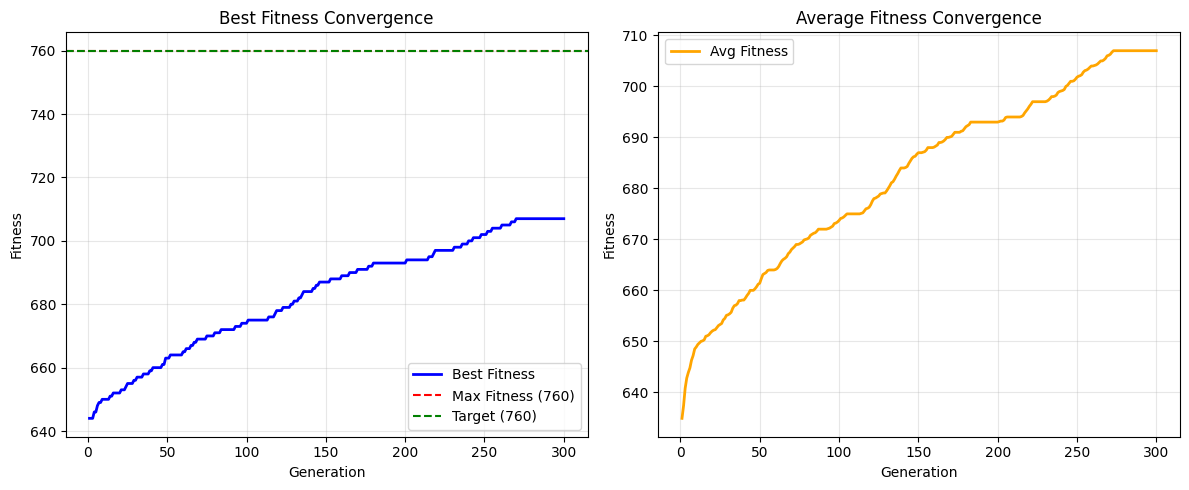

✅ Convergence plot saved to ../output/plot/convergence_plot_20251106_135232.png


In [51]:
plt.figure(figsize=(12, 5))

# Best Fitness
plt.subplot(1, 2, 1)
plt.plot(range(1, len(best_fitness_history) + 1), best_fitness_history, 'b-', linewidth=2, label='Best Fitness')
plt.axhline(y=max_fitness, color='r', linestyle='--', label=f'Max Fitness ({max_fitness})')
plt.axhline(y=TARGET_FITNESS * max_fitness, color='g', linestyle='--', label=f'Target ({TARGET_FITNESS * max_fitness:.0f})')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Best Fitness Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

# Average Fitness
plt.subplot(1, 2, 2)
plt.plot(range(1, len(avg_fitness_history) + 1), avg_fitness_history, 'orange', linewidth=2, label='Avg Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Average Fitness Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

# Generate timestamp for unique filename
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

plt.tight_layout()
plot_filename = f'{OUTPUT_DIR}/plot/convergence_plot_{timestamp}.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Convergence plot saved to {plot_filename}")

## 13. Export Best Solution to Excel

In [52]:
# Generate timestamp for unique filename (reuse from previous cell if exists)
if 'timestamp' not in locals():
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Decode best solution
best_groups = decode_kromosom(best_overall_solution, df_clean, expected_sizes)

# Prepare export data
export_data = []
for i, group_df in enumerate(best_groups):
    group_num = i + 1
    
    # Calculate constraints
    c1 = evaluate_C1(group_df)
    c2 = evaluate_C2(group_df)
    c3 = evaluate_C3(group_df, PL, PP)
    c4 = evaluate_C4(group_df, expected_sizes[i])
    group_fitness = c1 + c2 + c3 + c4
    
    # Add each student
    for _, student in group_df.iterrows():
        export_data.append({
            'Kelompok': group_num,
            'ID': student['ID'],
            'Jenis Kelamin': student['Jenis Kelamin'],
            'Jurusan': student['Jurusan'],
            'HTQ': student['HTQ'],
            'C1': c1,
            'C2': c2,
            'C3': c3,
            'C4': c4,
            'Group Fitness': group_fitness
        })

# Create DataFrame and export with timestamp as CSV
result_df = pd.DataFrame(export_data)
hasil_file = f'{OUTPUT_DIR}/hasil/best_solution_kelompok_kkm_{timestamp}.csv'
result_df.to_csv(hasil_file, index=False)

print("="*80)
print("✅ GROUPING RESULT EXPORTED")
print("="*80)
print(f"File saved: {hasil_file}")
print(f"Total rows: {len(result_df)}")
print(f"Total groups: {K}")
print(f"Best fitness: {best_overall_fitness:.0f}/{max_fitness} ({best_overall_fitness/max_fitness:.2%})")
print(f"Timestamp: {timestamp}")
print("="*80)

# Show sample
print("\n📊 Sample output (first 10 rows):")
result_df.head(10)

✅ GROUPING RESULT EXPORTED
File saved: ../output/hasil/best_solution_kelompok_kkm_20251106_135232.csv
Total rows: 2338
Total groups: 190
Best fitness: 707/760 (93.03%)
Timestamp: 20251106_135232

📊 Sample output (first 10 rows):


,Kelompok,ID,Jenis Kelamin,Jurusan,HTQ,C1,C2,C3,C4,Group Fitness
0,1,2,PR,BIOLOGI,0,1,1,1,1,4
1,1,603,PR,PERPUSTAKAAN DAN ILMU INFORMASI,0,1,1,1,1,4
2,1,808,PR,BIOLOGI,0,1,1,1,1,4
3,1,829,LK,PSIKOLOGI,0,1,1,1,1,4
4,1,933,LK,BAHASA DAN SASTRA ARAB,0,1,1,1,1,4
5,1,951,PR,HUKUM BISNIS SYARI'AH,0,1,1,1,1,4
6,1,1401,PR,BAHASA DAN SASTRA INGGRIS,0,1,1,1,1,4
7,1,1513,PR,BIOLOGI,0,1,1,1,1,4
8,1,1783,LK,TEKNIK INFORMATIKA,0,1,1,1,1,4
9,1,2174,LK,BAHASA DAN SASTRA ARAB,1,1,1,1,1,4


## 14. Export GA Statistics

In [53]:
# Reuse timestamp from previous cells
if 'timestamp' not in locals():
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Prepare GA statistics
ga_stats = {
    'Timestamp': timestamp,
    'Run Date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    
    # Dataset Info
    'Total Students': N,
    'Number of Groups': K,
    'Male Students': preprocessed['L'],
    'Female Students': preprocessed['P'],
    'Male Proportion': f"{preprocessed['PL']:.2%}",
    'Female Proportion': f"{preprocessed['PP']:.2%}",
    'Unique Majors': df_clean['Jurusan'].nunique(),
    'HTQ Members': df_clean['HTQ'].sum(),
    
    # GA Parameters
    'Population Size': POPSIZE,
    'Crossover Rate': CR,
    'Mutation Rate': MR,
    'Max Generation': MAX_GENERATION,
    'Target Fitness': TARGET_FITNESS,
    'Max Possible Fitness': max_fitness,
    
    # Results
    'Final Generation': generation,
    'Best Fitness': best_overall_fitness,
    'Best Fitness Percentage': f"{best_overall_fitness/max_fitness:.2%}",
    'Average Final Fitness': f"{avg_fitness:.2f}",
    'Initial Best Fitness': best_fitness_history[0] if best_fitness_history else 0,
    'Fitness Improvement': best_overall_fitness - (best_fitness_history[0] if best_fitness_history else 0),
    
    # Performance
    'Total Runtime (seconds)': f"{total_time:.2f}",
    'Total Runtime (minutes)': f"{total_time/60:.2f}",
    'Avg Time per Generation (seconds)': f"{total_time/generation:.2f}",
    'Initial Fitness Calculation Time (seconds)': f"{init_fitness_time:.2f}",
    
    # Convergence
    'Generations to Best': best_fitness_history.index(best_overall_fitness) + 1 if best_overall_fitness in best_fitness_history else generation,
    'Target Reached': 'Yes' if best_overall_fitness >= TARGET_FITNESS * max_fitness else 'No',
    'Convergence Rate': f"{(best_overall_fitness - best_fitness_history[0]) / generation:.2f}" if generation > 0 and best_fitness_history else 0,
}

# Calculate constraint satisfaction statistics
constraint_stats = {
    'C1_satisfied': 0,  # HTQ >= 1
    'C2_satisfied': 0,  # Jurusan > 50%
    'C3_satisfied': 0,  # Gender ±10%
    'C4_satisfied': 0,  # Exact size
    'perfect_groups': 0  # All 4 constraints satisfied
}

for i, group_df in enumerate(best_groups):
    c1 = evaluate_C1(group_df)
    c2 = evaluate_C2(group_df)
    c3 = evaluate_C3(group_df, PL, PP)
    c4 = evaluate_C4(group_df, expected_sizes[i])
    
    constraint_stats['C1_satisfied'] += c1
    constraint_stats['C2_satisfied'] += c2
    constraint_stats['C3_satisfied'] += c3
    constraint_stats['C4_satisfied'] += c4
    
    if c1 + c2 + c3 + c4 == 4:
        constraint_stats['perfect_groups'] += 1

# Add constraint stats to GA stats
ga_stats.update({
    'Groups with HTQ (C1)': constraint_stats['C1_satisfied'],
    'Groups with HTQ %': f"{constraint_stats['C1_satisfied']/K:.2%}",
    'Groups with Diverse Majors (C2)': constraint_stats['C2_satisfied'],
    'Groups with Diverse Majors %': f"{constraint_stats['C2_satisfied']/K:.2%}",
    'Groups with Balanced Gender (C3)': constraint_stats['C3_satisfied'],
    'Groups with Balanced Gender %': f"{constraint_stats['C3_satisfied']/K:.2%}",
    'Groups with Correct Size (C4)': constraint_stats['C4_satisfied'],
    'Groups with Correct Size %': f"{constraint_stats['C4_satisfied']/K:.2%}",
    'Perfect Groups (All Constraints)': constraint_stats['perfect_groups'],
    'Perfect Groups %': f"{constraint_stats['perfect_groups']/K:.2%}",
})

# Export to CSV
stats_df = pd.DataFrame([ga_stats]).T
stats_df.columns = ['Value']
stats_file = f'{OUTPUT_DIR}/statistik/ga_statistics_{timestamp}.csv'
stats_df.to_csv(stats_file, header=True)

# Also export fitness history
history_df = pd.DataFrame({
    'Generation': range(1, len(best_fitness_history) + 1),
    'Best_Fitness': best_fitness_history,
    'Avg_Fitness': avg_fitness_history,
    'Best_Fitness_Percentage': [f/max_fitness for f in best_fitness_history]
})
history_file = f'{OUTPUT_DIR}/statistik/fitness_history_{timestamp}.csv'
history_df.to_csv(history_file, index=False)

print("="*80)
print("✅ GA STATISTICS EXPORTED")
print("="*80)
print(f"Statistics file: {stats_file}")
print(f"Fitness history: {history_file}")
print("="*80)
print("\n📊 Key Statistics:")
print(f"   Best Fitness: {best_overall_fitness:.0f}/{max_fitness} ({best_overall_fitness/max_fitness:.2%})")
print(f"   Final Generation: {generation}/{MAX_GENERATION}")
print(f"   Total Runtime: {total_time/60:.2f} minutes")
print(f"   Perfect Groups: {constraint_stats['perfect_groups']}/{K} ({constraint_stats['perfect_groups']/K:.2%})")
print(f"   C1 (HTQ): {constraint_stats['C1_satisfied']}/{K} ({constraint_stats['C1_satisfied']/K:.2%})")
print(f"   C2 (Majors): {constraint_stats['C2_satisfied']}/{K} ({constraint_stats['C2_satisfied']/K:.2%})")
print(f"   C3 (Gender): {constraint_stats['C3_satisfied']}/{K} ({constraint_stats['C3_satisfied']/K:.2%})")
print(f"   C4 (Size): {constraint_stats['C4_satisfied']}/{K} ({constraint_stats['C4_satisfied']/K:.2%})")
print("="*80)

✅ GA STATISTICS EXPORTED
Statistics file: ../output/statistik/ga_statistics_20251106_135232.csv
Fitness history: ../output/statistik/fitness_history_20251106_135232.csv

📊 Key Statistics:
   Best Fitness: 707/760 (93.03%)
   Final Generation: 300/300
   Total Runtime: 4.08 minutes
   Perfect Groups: 142/190 (74.74%)
   C1 (HTQ): 159/190 (83.68%)
   C2 (Majors): 189/190 (99.47%)
   C3 (Gender): 169/190 (88.95%)
   C4 (Size): 190/190 (100.00%)
